### Runs our trained U-Net based model on test dataset and save results


Runing on: cuda
Train images: 96 (augmentation: True)
Test images: 24 (augmentation: False)
Model loaded on: cuda

6-vahadane_et_al 2019-10-31 19:40:01.881323
	Batch 1: 1/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:07.685428
	Batch 2: 2/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:22.928621
	Batch 3: 3/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:23.265524
	Batch 4: 4/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:23.594124
	Batch 5: 5/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:23.893177
	Batch 6: 6/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:24.292350
	Batch 7: 7/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:24.581346
	Batch 8: 8/24 images: torch.Size([1, 3, 256, 448]) mask

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


	Batch 22: 22/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:29.142227
	Batch 23: 23/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:29.434921
	Batch 24: 24/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2019-10-31 19:40:29.733149


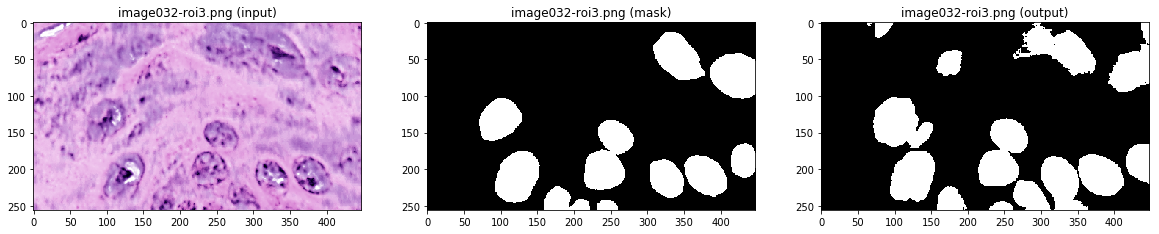

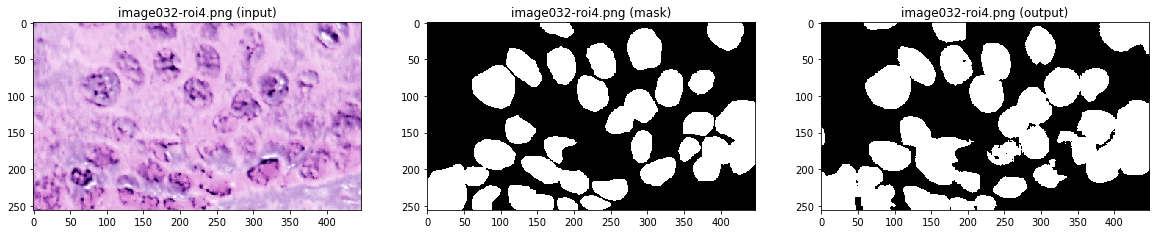

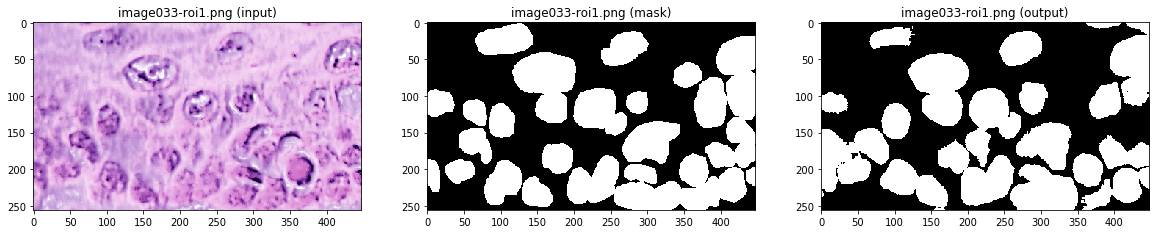

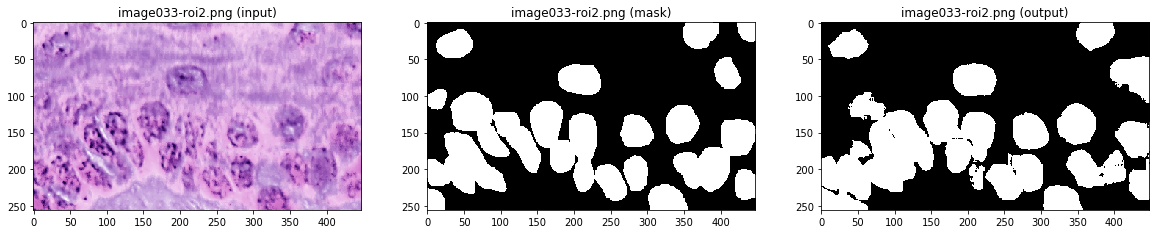

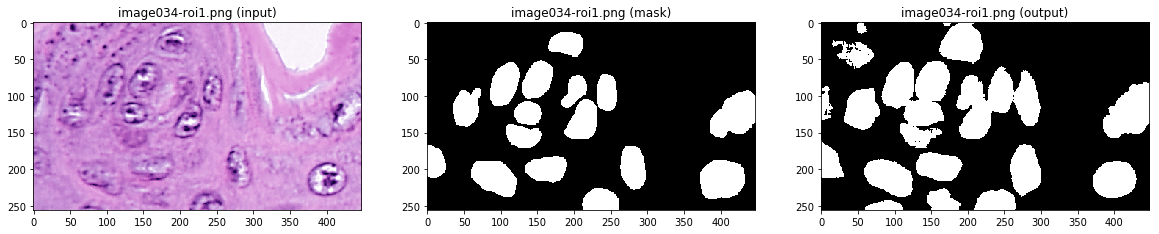

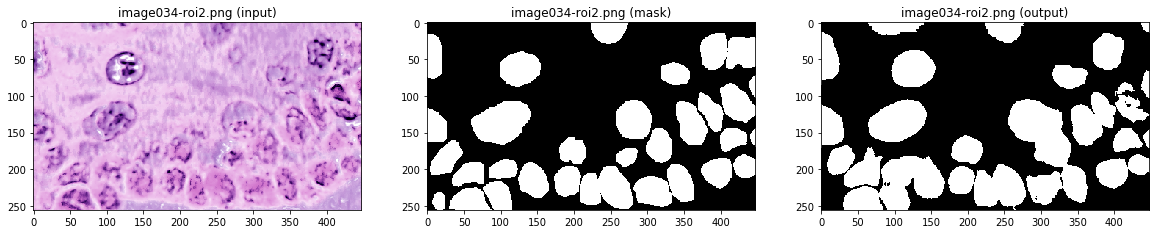

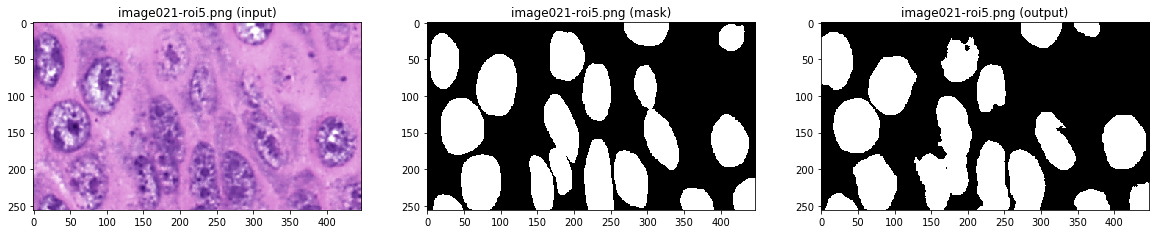

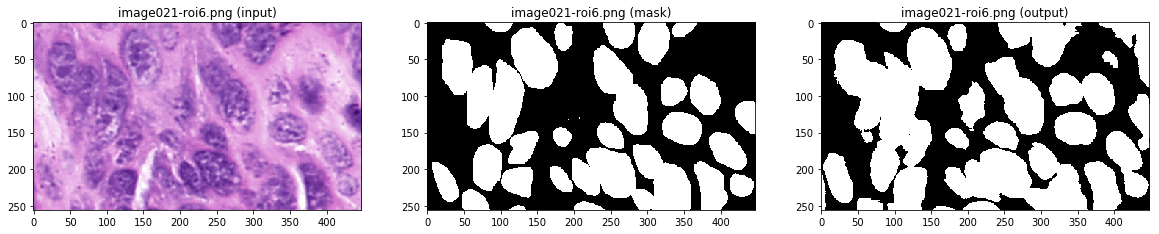

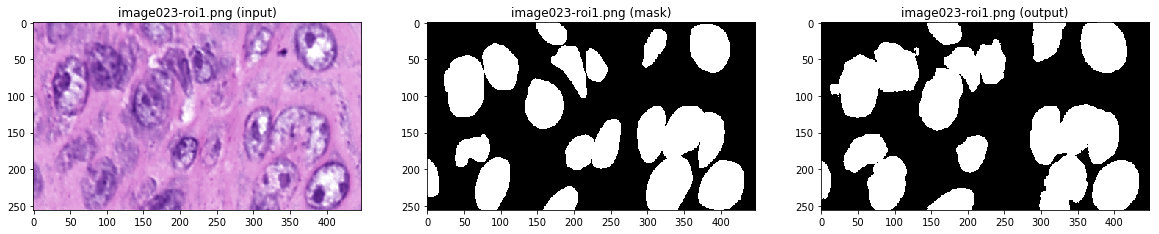

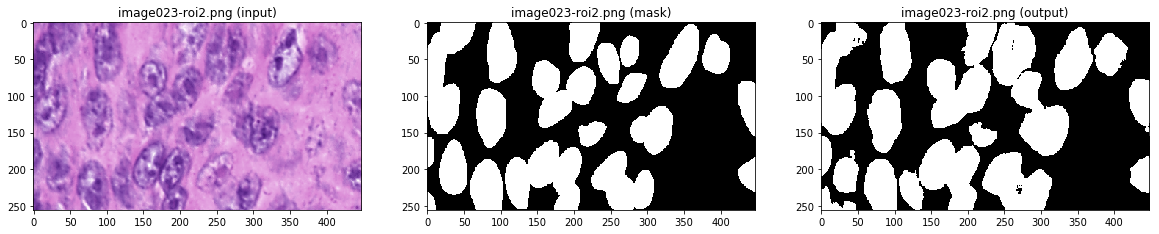

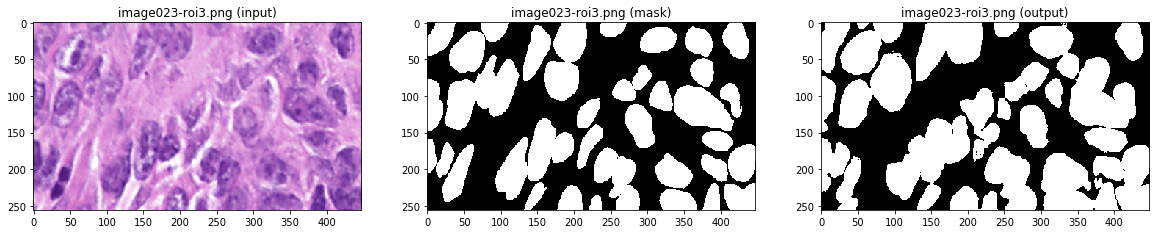

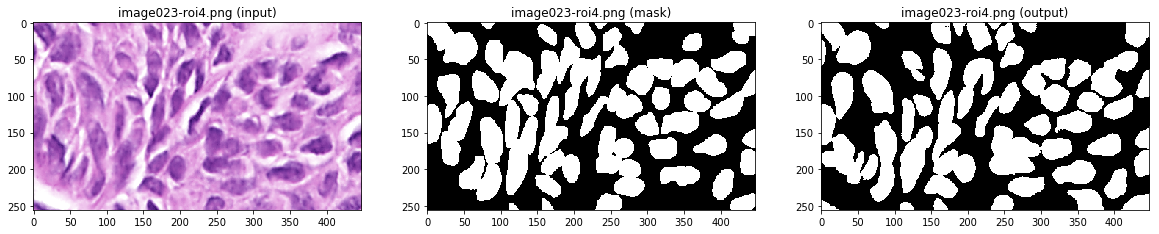

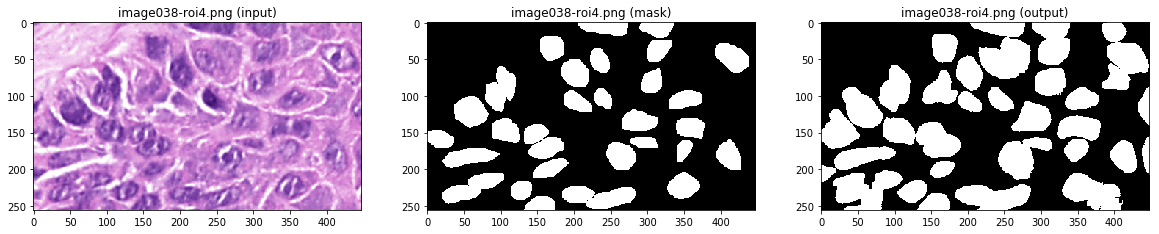

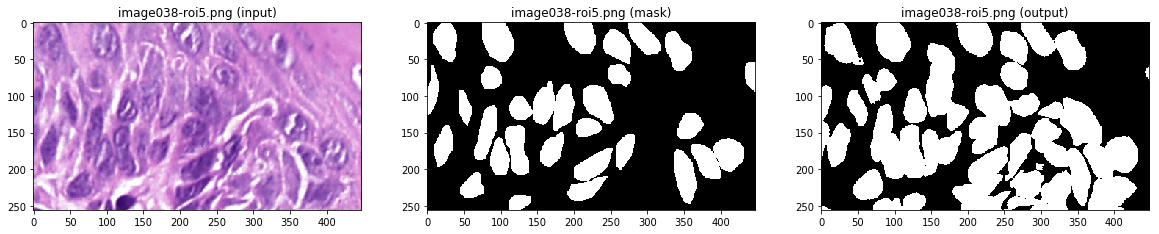

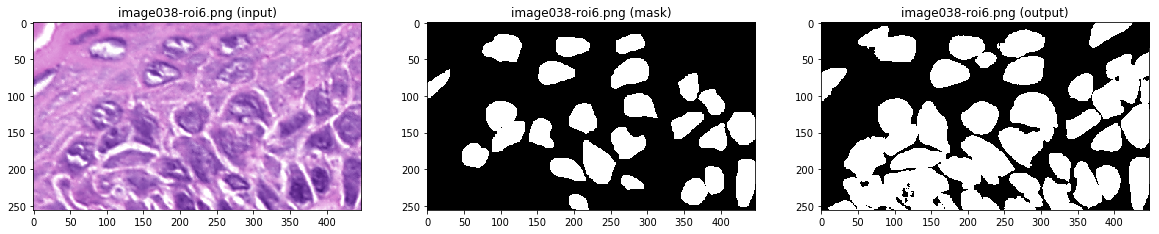

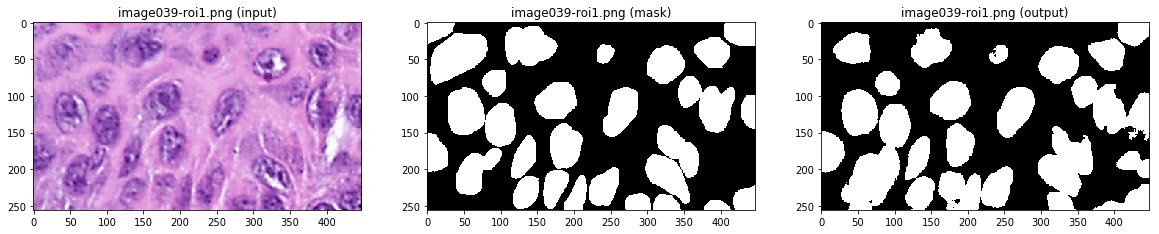

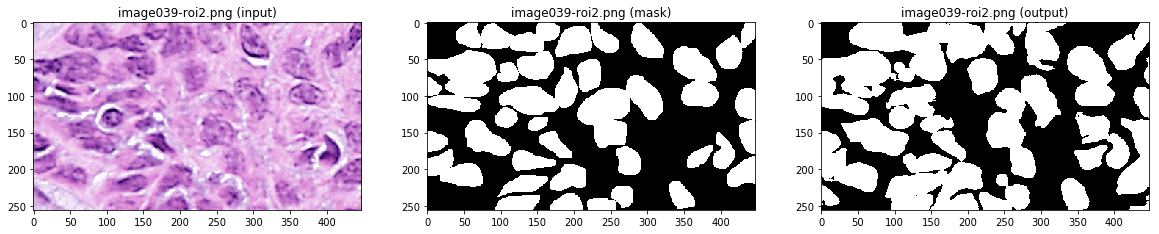

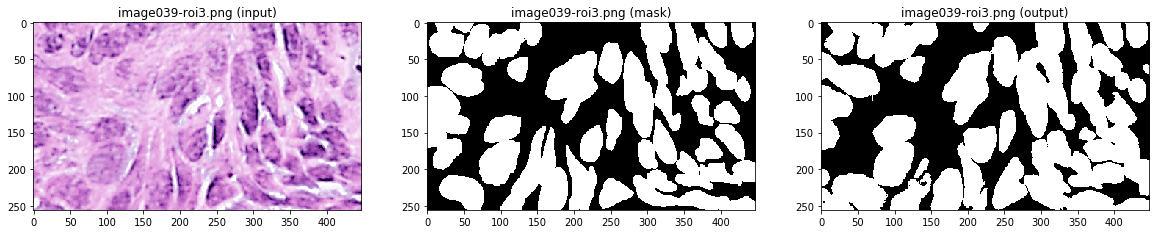

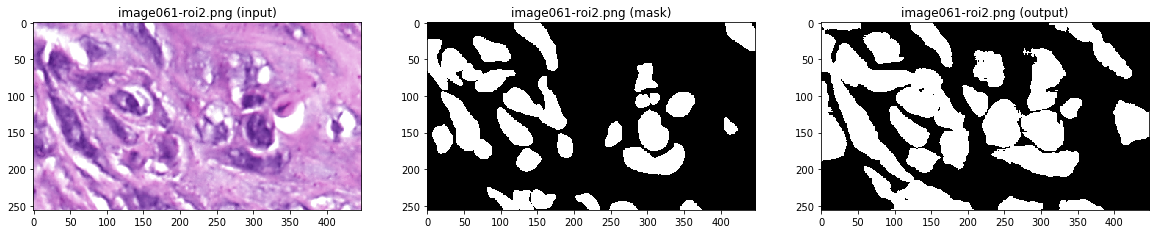

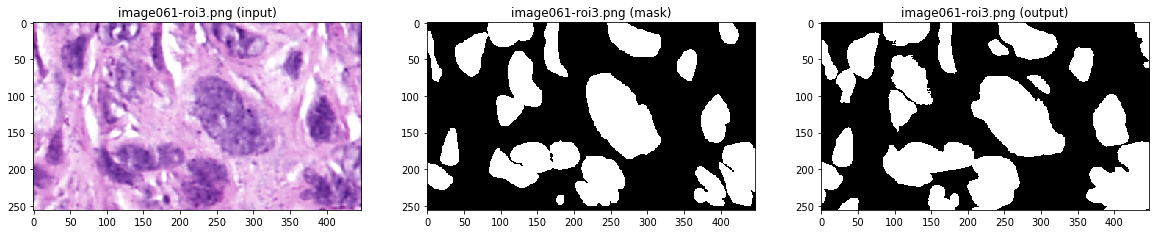

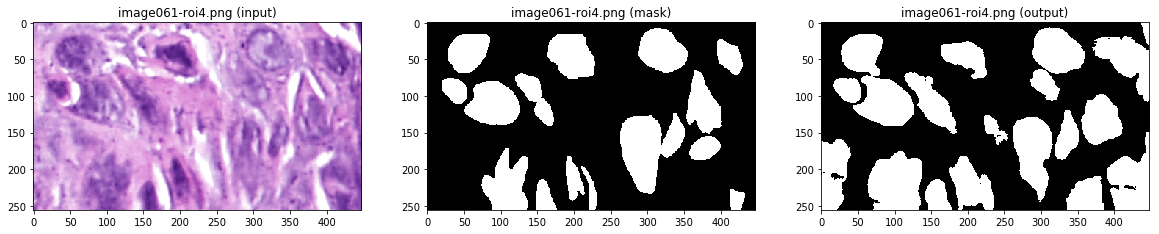

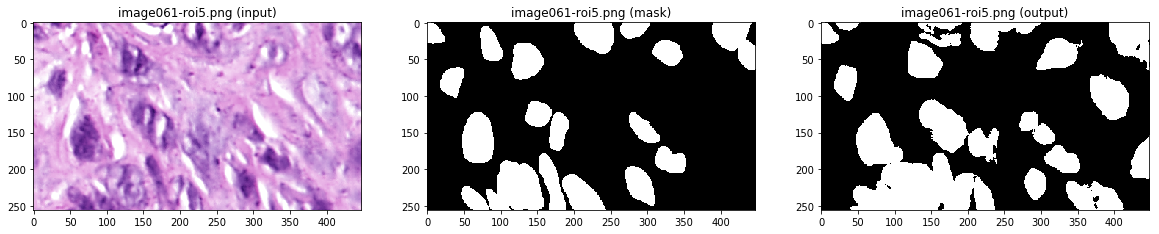

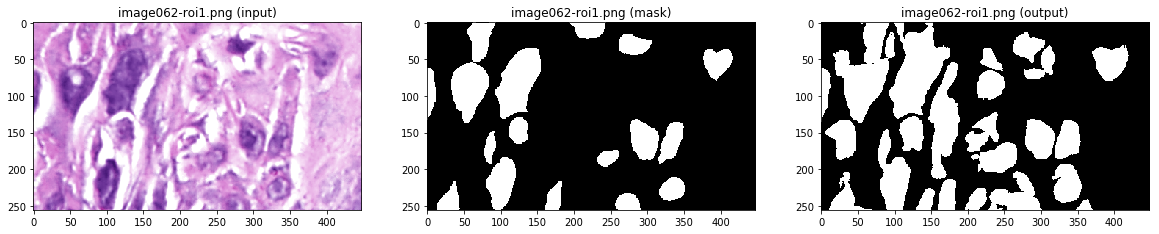

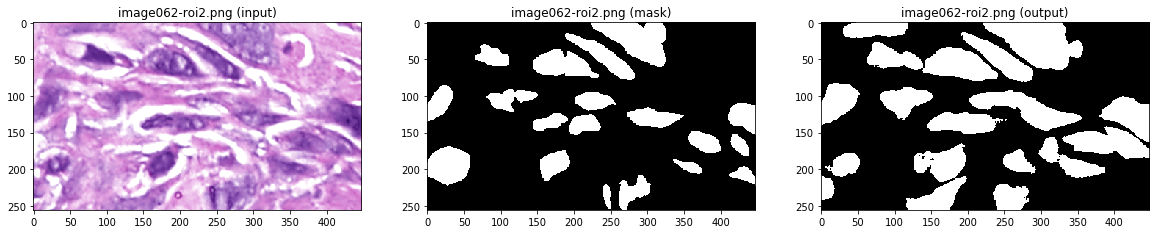

In [1]:
from unet_model import *
from oral_mice_tissues_dataset import *

from torchvision import transforms
from torchvision import utils
from torch.autograd import Variable

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print()
print('Runing on: {}'.format(device))

color_norm_methods = ["1-original", "2-khan_et_al", "3-macenko_et_al", "4-tosta_et_al", "5-reinhard_et_al", "6-vahadane_et_al"]
for color_normalization in color_norm_methods:

    # create the datasets
    batch_size = 1
    dataset_dir = "/home/dalifreire/notebooks/github/histological_oral_mice_tissues/roi"
    dataloaders = create_dataloader(method=color_normalization, batch_size=batch_size, dataset_dir=dataset_dir)


    # directory to save results
    seg_method = "1-unet_based"
    results_dir = "results/{}/{}".format(color_normalization, seg_method)
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)


    # load the trained model
    epoch = 500
    model = UNet(in_channels=3, out_channels=1, padding=True).to(device)
    model = load_checkpoint(file_path="{}__Dataset-{}__Epoch-{}__Size-448x256.pt".format(model.name(), color_normalization, epoch))
    print()

    # iterate over test dataset images        
    t1 = datetime.now()
    print("{} {}".format(color_normalization, t1))
    for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):

        t = datetime.now()

        X = Variable(images.to(device))
        print('\tBatch {}: {}/{} images: {} masks: {} {}'.format(
            (batch_idx+1), 
            (batch_idx+1) * len(images), 
            len(dataloaders['test'].dataset),
            images.shape,
            masks.shape,
            datetime.now()))


        y_hat = model(X).squeeze(0)
        X_numpy = X.cpu().numpy()
        y_hat_numpy = y_hat.detach().cpu().numpy()


        input_image_filename  = '{}/{} - input.png'.format(results_dir, fname[0][0:-4])
        mask_image_filename   = '{}/{} - mask.png'.format(results_dir, fname[0][0:-4])
        output_image_filename = '{}/{} - output - 1.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_otsu  = '{}/{} - output - 2 - otsu.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_hyst  = '{}/{} - output - 3 - hysteresis.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_basic = '{}/{} - output - 4 - basic.png'.format(results_dir, fname[0][0:-4])
        f, ax = plt.subplots(1, 3, figsize=(20, 20))


        # save the input image
        input_image = images[0]
        utils.save_image(input_image, input_image_filename)
        ax[0].imshow(input_image.permute(1, 2, 0))
        ax[0].set_title('{} (input)'.format(fname[0]))

        # save the mask image
        mask_image = masks[0]
        utils.save_image(mask_image, mask_image_filename)
        ax[1].imshow(mask_image, cmap='gray')
        ax[1].set_title('{} (mask)'.format(fname[0]))

        # save the predicted output image
        output_image = y_hat[0].squeeze(0).detach().cpu().numpy()
        output_image_otsu  = otsu_threshold(np_img=output_image)
        output_image_hyst  = hysteresis_threshold(np_img=output_image, low=0.2, high=0.8)
        output_image_basic = basic_threshold(np_img=output_image, threshold=0.2)

        utils.save_image(y_hat[0], output_image_filename)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_otsu)), output_image_filename_otsu)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_hyst)), output_image_filename_hyst)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_basic)), output_image_filename_basic)

        ax[2].imshow(output_image_hyst, cmap='gray')
        ax[2].set_title('{} (output)'.format(fname[0]))
        

### Qualitative analysis

In [8]:
from torchvision import utils
from torchvision import transforms
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections

color_norm_methods = ["1-original", "2-khan_et_al", "3-macenko_et_al", "4-tosta_et_al", "5-reinhard_et_al", "6-vahadane_et_al"]
seg_methods = ["1-unet_based", "2-de_oliveira_et_al_(2013)", "3-phoulady_et_al_(2016)", "4-vahadane_and_sethi_(2013)", "5-wienert_et_al_(2012)"]
results_dir = "/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results"
#results_dir = "/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                    for file in sorted(f_sef):
                        
                        threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                        if file.lower().endswith(threshold_type):
                            
                            input_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'input.png'))
                            mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'mask.png'))
                            output_filename = "{}/{}/{}".format(r, seg_method, file)

                            input_image = load_pil_image(input_filename)
                            mask_image = load_pil_image(mask_filename, gray=True)
                            output_image = load_pil_image(output_filename, gray=True)

                            
                            merge_image_output_b = cut_image_by_mask(input_image, output_image, inverse=True)
                            merge_image_mask_b = cut_image_by_mask(input_image, mask_image, inverse=True)

                            merge_image_output_f = cut_image_by_mask(input_image, output_image, inverse=False)
                            merge_image_mask_f = cut_image_by_mask(input_image, mask_image, inverse=False)

                                                        
                            utils.save_image(transforms.ToTensor()(merge_image_output_f), output_filename.replace(".png", "_2.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_f), output_filename.replace(".png", "_3.png"))
                            
                            utils.save_image(transforms.ToTensor()(merge_image_output_b), output_filename.replace(".png", "_4.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_b), output_filename.replace(".png", "_5.png"))


/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results/5-reinhard_et_al
	4-vahadane_and_sethi_(2013)


### Quantitative analysis

In [9]:
from torchvision import utils
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections


color_norm_methods = ["1-original", "2-khan_et_al", "3-macenko_et_al", "4-tosta_et_al", "5-reinhard_et_al", "6-vahadane_et_al"]
seg_methods = ["1-unet_based", "2-de_oliveira_et_al_(2013)", "3-phoulady_et_al_(2016)", "4-vahadane_and_sethi_(2013)", "5-wienert_et_al_(2012)"]
#results_dir = "/home/dalifreire/notebooks/github/dysplastic_oral_tissues_segmentation/results"
results_dir = "/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                if os.path.exists(seg_method_dir):
                    with open('{}/quantitative_analysis.csv'.format(seg_method_dir), mode='w') as medidas_file:
                        medidas_writer = csv.writer(medidas_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        medidas_writer.writerow(['image', 'accuracy', 'precision', 'f1/dice', 'jaccard', 'sensitivity/recall', 'specificity'])

                        for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                            for file in sorted(f_sef):

                                threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                                if file.lower().endswith(threshold_type):

                                    mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, "mask.png"))
                                    output_filename = "{}/{}/{}".format(r, seg_method, file)

                                    accuracy = pixel_accuracy_score(mask_filename, output_filename)
                                    jaccard = jaccard_index_score(mask_filename, output_filename)
                                    precision = precision_score(mask_filename, output_filename)
                                    recall = recall_score(mask_filename, output_filename)
                                    f1 = f1_score(mask_filename, output_filename)
                                    sensitivity = sensitivity_score(mask_filename, output_filename)
                                    specificity = specificity_score(mask_filename, output_filename)
                                    dice = dice_score(mask_filename, output_filename)

                                    print(file.replace(" - " + threshold_type, ""))
                                    print('\t{}: \t\t{}'.format('accuracy', accuracy))
                                    print('\t{}: \t\t{}'.format('precision', precision))
                                    print('\t{}: \t\t{}'.format('f1/dice', f1))
                                    print('\t{}: \t\t{}'.format('jaccard', jaccard))
                                    print('\t{}: \t{}'.format('sensitivity/recall', sensitivity))
                                    print('\t{}: \t\t{}'.format('specificity', specificity))
                                    print()

                                    medidas_writer.writerow([file.replace(" - " + threshold_type, ""), accuracy, precision, f1, jaccard, sensitivity, specificity])

/home/dalifreire/Documents/Doutorado/github/dysplastic_oral_tissues_segmentation/results/1-original
	1-unet_based
image021-roi5
	accuracy: 		0.9317278180803571
	precision: 		0.9195976331360947
	f1/dice: 		0.9084595959595959
	jaccard: 		0.832272990167727
	sensitivity/recall: 	0.8975881347317839
	specificity: 		0.9524243018402846

image021-roi6
	accuracy: 		0.8722011021205357
	precision: 		0.8365907681403384
	f1/dice: 		0.865634425162491
	jaccard: 		0.7631000484887668
	sensitivity/recall: 	0.8967672086309072
	specificity: 		0.8513539651837524

image023-roi1
	accuracy: 		0.9143240792410714
	precision: 		0.8623969861078409
	f1/dice: 		0.8817256072606466
	jaccard: 		0.7884698183070696
	sensitivity/recall: 	0.9019405043341213
	specificity: 		0.9211123110151188

image023-roi2
	accuracy: 		0.8812691824776786
	precision: 		0.8416412886680558
	f1/dice: 		0.8605287146763901
	jaccard: 		0.7552
	sensitivity/recall: 	0.880283313425955
	specificity: 		0.8819717174130542

image023-roi3
	accuracy: 		0.

image038-roi6
	accuracy: 		0.78277587890625
	precision: 		0.5347081033981993
	f1/dice: 		0.5964395056128813
	jaccard: 		0.42494748747778316
	sensitivity/recall: 	0.6742848771197304
	specificity: 		0.8166733421067689

image039-roi1
	accuracy: 		0.7737165178571429
	precision: 		0.8519392917369308
	f1/dice: 		0.660633957526938
	jaccard: 		0.49324377099117395
	sensitivity/recall: 	0.5394899833411644
	specificity: 		0.9353137064214776

image039-roi2
	accuracy: 		0.80914306640625
	precision: 		0.7939431782703715
	f1/dice: 		0.7880307945576914
	jaccard: 		0.6502069450437061
	sensitivity/recall: 	0.7822058173289501
	specificity: 		0.8315010132278087

image039-roi3
	accuracy: 		0.8138340541294643
	precision: 		0.8721242086442502
	f1/dice: 		0.8174426061305631
	jaccard: 		0.6912498373172531
	sensitivity/recall: 	0.7692134397528322
	specificity: 		0.8666070341047503

image061-roi2
	accuracy: 		0.68768310546875
	precision: 		0.4188337197938026
	f1/dice: 		0.549622159912487
	jaccard: 		0.3789510186

image023-roi3
	accuracy: 		0.6437901088169643
	precision: 		0.8961499189140489
	f1/dice: 		0.4221068564072822
	jaccard: 		0.267512954296882
	sensitivity/recall: 	0.2760713492709644
	specificity: 		0.9714893476683596

image023-roi4
	accuracy: 		0.6789376395089286
	precision: 		0.9022741516698003
	f1/dice: 		0.5226105896385418
	jaccard: 		0.3537392281095881
	sensitivity/recall: 	0.36783224440632184
	specificity: 		0.9635522756870472

image032-roi3
	accuracy: 		0.7830461774553571
	precision: 		0.41233071988595865
	f1/dice: 		0.21813725490196073
	jaccard: 		0.12242090784044017
	sensitivity/recall: 	0.14829530889515508
	specificity: 		0.9458053066321948

image032-roi4
	accuracy: 		0.7295793805803571
	precision: 		0.8103844087334539
	f1/dice: 		0.5168857872764658
	jaccard: 		0.34851381157441447
	sensitivity/recall: 	0.37945703634242844
	specificity: 		0.945296977383217

image033-roi1
	accuracy: 		0.6668875558035714
	precision: 		0.8472202235333621
	f1/dice: 		0.4804156239799804
	jaccard: 		0

image061-roi2
	accuracy: 		0.7807878766741071
	precision: 		0.5675957120980092
	f1/dice: 		0.4243354017356261
	jaccard: 		0.2693056645450054
	sensitivity/recall: 	0.3388181951148164
	specificity: 		0.91917792534921

image061-roi3
	accuracy: 		0.7342006138392857
	precision: 		0.7693173293323331
	f1/dice: 		0.4022041808840256
	jaccard: 		0.2517243918603795
	sensitivity/recall: 	0.2722759133389975
	specificity: 		0.960077378479435

image061-roi4
	accuracy: 		0.7761143275669643
	precision: 		0.63608283963745
	f1/dice: 		0.49455719375602836
	jaccard: 		0.328512774915662
	sensitivity/recall: 	0.40454721112971787
	specificity: 		0.9140681046439333

image061-roi5
	accuracy: 		0.7848074776785714
	precision: 		0.5705686103858427
	f1/dice: 		0.3893205324887415
	jaccard: 		0.24171198574369374
	sensitivity/recall: 	0.2954630811988282
	specificity: 		0.9327632804160705

image062-roi1
	accuracy: 		0.7958722795758929
	precision: 		0.4136264068283103
	f1/dice: 		0.318714896836714
	jaccard: 		0.18956624

image033-roi1
	accuracy: 		0.4593418666294643
	precision: 		0.4593418666294643
	f1/dice: 		0.6295192060656394
	jaccard: 		0.4593418666294643
	sensitivity/recall: 	1.0
	specificity: 		0.0

image033-roi2
	accuracy: 		0.35329764229910715
	precision: 		0.35329764229910715
	f1/dice: 		0.5221285122449374
	jaccard: 		0.35329764229910715
	sensitivity/recall: 	1.0
	specificity: 		0.0

image034-roi1
	accuracy: 		0.22217668805803573
	precision: 		0.22217668805803573
	f1/dice: 		0.36357539826923213
	jaccard: 		0.22217668805803573
	sensitivity/recall: 	1.0
	specificity: 		0.0

image034-roi2
	accuracy: 		0.3587733677455357
	precision: 		0.3587733677455357
	f1/dice: 		0.528084191612924
	jaccard: 		0.3587733677455357
	sensitivity/recall: 	1.0
	specificity: 		0.0

image038-roi4
	accuracy: 		0.8419276646205357
	precision: 		0.7634640810929925
	f1/dice: 		0.6564850781620085
	jaccard: 		0.4886325172063635
	sensitivity/recall: 	0.5758018946318764
	specificity: 		0.936562533243502

image038-roi5
	accuracy: 

image021-roi5
	accuracy: 		0.7065952845982143
	precision: 		0.9497759522031367
	f1/dice: 		0.3768287714359791
	jaccard: 		0.2321558963125228
	sensitivity/recall: 	0.23504135286235733
	specificity: 		0.9924651970533038

image021-roi6
	accuracy: 		0.6843697684151786
	precision: 		0.9356889336229274
	f1/dice: 		0.4938972387277176
	jaccard: 		0.3279306375552338
	sensitivity/recall: 	0.33549232639416504
	specificity: 		0.9804319793681496

image023-roi1
	accuracy: 		0.7000034877232143
	precision: 		0.7968032159264931
	f1/dice: 		0.3261125039172673
	jaccard: 		0.19482343029650606
	sensitivity/recall: 	0.20500886524822695
	specificity: 		0.9713417926565875

image023-roi2
	accuracy: 		0.7518572126116071
	precision: 		0.9513120899718838
	f1/dice: 		0.5879150316386962
	jaccard: 		0.41634536505332237
	sensitivity/recall: 	0.42541019676871816
	specificity: 		0.9844848955455672

image023-roi3
	accuracy: 		0.6874128069196429
	precision: 		0.9341828942344407
	f1/dice: 		0.5219745053069497
	jaccard: 		

image039-roi3
	accuracy: 		0.5689958844866071
	precision: 		0.8568060623070446
	f1/dice: 		0.381795670281019
	jaccard: 		0.23593786227683747
	sensitivity/recall: 	0.24562306900102987
	specificity: 		0.9514502131546894

image061-roi2
	accuracy: 		0.8199637276785714
	precision: 		0.7280152463925946
	f1/dice: 		0.5088487155090391
	jaccard: 		0.34124553343542624
	sensitivity/recall: 	0.3911072107649554
	specificity: 		0.9542477673460041

image061-roi3
	accuracy: 		0.75714111328125
	precision: 		0.9287649680971943
	f1/dice: 		0.43278688524590175
	jaccard: 		0.27615062761506276
	sensitivity/recall: 	0.2821261682242991
	specificity: 		0.9894188824262568

image061-roi4
	accuracy: 		0.7914951869419643
	precision: 		0.6941739650764293
	f1/dice: 		0.5162738950136543
	jaccard: 		0.34795768119103454
	sensitivity/recall: 	0.4109558160504959
	specificity: 		0.9327801425223587

image061-roi5
	accuracy: 		0.8241838727678571
	precision: 		0.7323457500359557
	f1/dice: 		0.5025165301490181
	jaccard: 		0.3

image032-roi3
	accuracy: 		0.7359444754464286
	precision: 		0.3469923473927745
	f1/dice: 		0.33995902532583583
	jaccard: 		0.20478953863928787
	sensitivity/recall: 	0.3332051610698112
	specificity: 		0.8392125501194102

image032-roi4
	accuracy: 		0.7767072405133929
	precision: 		0.9529405881176235
	f1/dice: 		0.5980947598047678
	jaccard: 		0.42662994805660037
	sensitivity/recall: 	0.4358118152917229
	specificity: 		0.9867399422250405

image033-roi1
	accuracy: 		0.6848929268973214
	precision: 		0.9189969604863222
	f1/dice: 		0.5009872826942461
	jaccard: 		0.3342114959469418
	sensitivity/recall: 	0.3443556500446081
	specificity: 		0.9742125889012531

image033-roi2
	accuracy: 		0.7765154157366071
	precision: 		0.9380369542191361
	f1/dice: 		0.5543442352163859
	jaccard: 		0.38345521023765994
	sensitivity/recall: 	0.39342037069029345
	specificity: 		0.985802693847834

image034-roi1
	accuracy: 		0.5827898297991071
	precision: 		0.266503820618815
	f1/dice: 		0.34791970454762267
	jaccard: 		0.

image061-roi4
	accuracy: 		0.7034824916294643
	precision: 		0.4247440533795141
	f1/dice: 		0.32905198776758404
	jaccard: 		0.19692532942898974
	sensitivity/recall: 	0.2685495298209455
	specificity: 		0.8649624563585059

image061-roi5
	accuracy: 		0.7238071986607143
	precision: 		0.33037753593980923
	f1/dice: 		0.23694353439969168
	jaccard: 		0.13439361643985354
	sensitivity/recall: 	0.1847066776834673
	specificity: 		0.8868070223251799

image062-roi1
	accuracy: 		0.7419695172991071
	precision: 		0.27775153519130846
	f1/dice: 		0.26343430320830324
	jaccard: 		0.1516984377239501
	sensitivity/recall: 	0.25052073470933534
	specificity: 		0.8529242016160061

image062-roi2
	accuracy: 		0.7458932059151786
	precision: 		0.3697602723968159
	f1/dice: 		0.35545725975892956
	jaccard: 		0.21614352188063155
	sensitivity/recall: 	0.3422195724384635
	specificity: 		0.8498234765256671

	4-vahadane_and_sethi_(2013)
image021-roi5
	accuracy: 		0.5502406529017857
	precision: 		0.3300557194362504
	f1/dice: 

image034-roi1
	accuracy: 		0.7786690848214286
	precision: 		0.5048091224590977
	f1/dice: 		0.2862846538829219
	jaccard: 		0.1670549630844955
	sensitivity/recall: 	0.19979592637651583
	specificity: 		0.944017846133151

image034-roi2
	accuracy: 		0.7461199079241071
	precision: 		0.899402390438247
	f1/dice: 		0.4819684380948992
	jaccard: 		0.31749566358820497
	sensitivity/recall: 	0.32918560283860304
	specificity: 		0.9793992466787235

image038-roi4
	accuracy: 		0.6887642996651786
	precision: 		0.3263372956909361
	f1/dice: 		0.22799922140277265
	jaccard: 		0.12866767563345213
	sensitivity/recall: 	0.17520358982881834
	specificity: 		0.8713875394489558

image038-roi5
	accuracy: 		0.712646484375
	precision: 		0.5161506276150628
	f1/dice: 		0.27236598074715185
	jaccard: 		0.15765259175953378
	sensitivity/recall: 	0.18499190210545258
	specificity: 		0.9289209057605783

image038-roi6
	accuracy: 		0.7354910714285714
	precision: 		0.40580160258401143
	f1/dice: 		0.3010460347449426
	jaccard: 		0.

image021-roi5
	accuracy: 		0.7600446428571429
	precision: 		0.8574732450571376
	f1/dice: 		0.5788055955186875
	jaccard: 		0.4072670098429861
	sensitivity/recall: 	0.43683870073464864
	specificity: 		0.9559816251645612

image021-roi6
	accuracy: 		0.7612217494419643
	precision: 		0.8425863144476688
	f1/dice: 		0.694087288732001
	jaccard: 		0.5314959282830356
	sensitivity/recall: 	0.5900888922656131
	specificity: 		0.9064474532559639

image023-roi1
	accuracy: 		0.7536708286830357
	precision: 		0.8094355686883358
	f1/dice: 		0.5336194799834916
	jaccard: 		0.36390246099115126
	sensitivity/recall: 	0.3980003940110323
	specificity: 		0.9486366090712743

image023-roi2
	accuracy: 		0.7596522739955357
	precision: 		0.8954017576898933
	f1/dice: 		0.6234752557745632
	jaccard: 		0.4529342886061881
	sensitivity/recall: 	0.47823809224450453
	specificity: 		0.9601893469918019

image023-roi3
	accuracy: 		0.7619105747767857
	precision: 		0.9057852243064408
	f1/dice: 		0.6861018507874468
	jaccard: 		0.52

image038-roi6
	accuracy: 		0.7791573660714286
	precision: 		0.5370085822433759
	f1/dice: 		0.530841329233505
	jaccard: 		0.361323347706584
	sensitivity/recall: 	0.5248141229901476
	specificity: 		0.858625622246381

image039-roi1
	accuracy: 		0.7493809291294643
	precision: 		0.9134232792133546
	f1/dice: 		0.5815365352978001
	jaccard: 		0.409976393308016
	sensitivity/recall: 	0.4265516210328478
	specificity: 		0.9721067986915393

image039-roi2
	accuracy: 		0.7252633231026786
	precision: 		0.9273568392098025
	f1/dice: 		0.5854678928049888
	jaccard: 		0.4138950892857143
	sensitivity/recall: 	0.42776400023069383
	specificity: 		0.9721880933765218

image039-roi3
	accuracy: 		0.6259765625
	precision: 		0.9291830181947913
	f1/dice: 		0.49276322013054585
	jaccard: 		0.3269315257641373
	sensitivity/recall: 	0.33528578784757984
	specificity: 		0.9697777101096224

image061-roi2
	accuracy: 		0.812255859375
	precision: 		0.6607873493309743
	f1/dice: 		0.5260817889686138
	jaccard: 		0.356927395991995

image023-roi3
	accuracy: 		0.6446533203125
	precision: 		0.9316616863713135
	f1/dice: 		0.4130879345603272
	jaccard: 		0.2603092783505155
	sensitivity/recall: 	0.26537636000296055
	specificity: 		0.9826528593100718

image023-roi4
	accuracy: 		0.7114519391741071
	precision: 		0.946761642030716
	f1/dice: 		0.5815303296619921
	jaccard: 		0.4099702248292831
	sensitivity/recall: 	0.41964448662262294
	specificity: 		0.9784118609543527

image032-roi3
	accuracy: 		0.8030744280133929
	precision: 		0.6254967899724855
	f1/dice: 		0.15339056115755142
	jaccard: 		0.08306605497137753
	sensitivity/recall: 	0.08741348372212253
	specificity: 		0.9865800486404768

image032-roi4
	accuracy: 		0.7021571568080357
	precision: 		0.9171318911374738
	f1/dice: 		0.38103176472720024
	jaccard: 		0.23535468851431512
	sensitivity/recall: 	0.24046840335750064
	specificity: 		0.9866131191432396

image033-roi1
	accuracy: 		0.6525966099330357
	precision: 		0.9798176110031395
	f1/dice: 		0.39685735478890083
	jaccard: 		0

image061-roi2
	accuracy: 		0.8325020926339286
	precision: 		0.601410627056126
	f1/dice: 		0.7152893051932653
	jaccard: 		0.5567707251793913
	sensitivity/recall: 	0.8823679976597923
	specificity: 		0.8168880238149759

image061-roi3
	accuracy: 		0.89678955078125
	precision: 		0.8210316967060286
	f1/dice: 		0.8480273209310685
	jaccard: 		0.7361522858480262
	sensitivity/recall: 	0.8768585386576041
	specificity: 		0.9065356252596594

image061-roi4
	accuracy: 		0.8295113699776786
	precision: 		0.6408190256925225
	f1/dice: 		0.7279809685452345
	jaccard: 		0.572303519478531
	sensitivity/recall: 	0.8425866288805874
	specificity: 		0.8246568463341145

image061-roi5
	accuracy: 		0.85791015625
	precision: 		0.654853990525874
	f1/dice: 		0.7283094364788263
	jaccard: 		0.5727096334364675
	sensitivity/recall: 	0.8203259971456471
	specificity: 		0.869273920646817

image062-roi1
	accuracy: 		0.8682948521205357
	precision: 		0.5969649128459581
	f1/dice: 		0.7104158279174096
	jaccard: 		0.550887521184550

image033-roi1
	accuracy: 		0.6949811662946429
	precision: 		0.8927699613865341
	f1/dice: 		0.5348880497792906
	jaccard: 		0.3650833983701472
	sensitivity/recall: 	0.3818264649494125
	specificity: 		0.9610366571516119

image033-roi2
	accuracy: 		0.7431379045758929
	precision: 		0.8632899750361319
	f1/dice: 		0.4715021259037333
	jaccard: 		0.30847417840375585
	sensitivity/recall: 	0.32431698709247514
	specificity: 		0.9719424557429653

image034-roi1
	accuracy: 		0.8223440987723214
	precision: 		0.6326233766233766
	f1/dice: 		0.5444993405021126
	jaccard: 		0.37409762541086844
	sensitivity/recall: 	0.47792472822887644
	specificity: 		0.9207237100227561

image034-roi2
	accuracy: 		0.785888671875
	precision: 		0.8445118152747207
	f1/dice: 		0.6235243614509551
	jaccard: 		0.45298612193980975
	sensitivity/recall: 	0.4942037086543369
	specificity: 		0.9490896234753403

image038-roi4
	accuracy: 		0.8321707589285714
	precision: 		0.7330838387748957
	f1/dice: 		0.6390909772744318
	jaccard: 		0.469

image062-roi1
	accuracy: 		0.8181326729910714
	precision: 		0.506208570628326
	f1/dice: 		0.5097541484510882
	jaccard: 		0.3420604378272664
	sensitivity/recall: 	0.5133497443665972
	specificity: 		0.8869436962934462

image062-roi2
	accuracy: 		0.8654436383928571
	precision: 		0.7142552964973917
	f1/dice: 		0.6349011072205923
	jaccard: 		0.4650953206239168
	sensitivity/recall: 	0.5714164040541692
	specificity: 		0.9411442229677872

	5-wienert_et_al_(2012)
image021-roi5
	accuracy: 		0.6639142717633929
	precision: 		0.7781297665141382
	f1/dice: 		0.2560172942924975
	jaccard: 		0.14680036301657923
	sensitivity/recall: 	0.15321351014184725
	specificity: 		0.9735161480070587

image021-roi6
	accuracy: 		0.6127406529017857
	precision: 		0.884982233027866
	f1/dice: 		0.2988222664266995
	jaccard: 		0.1756561119566428
	sensitivity/recall: 	0.17975991490654916
	specificity: 		0.980174081237911

image023-roi1
	accuracy: 		0.6944841657366071
	precision: 		0.8214986722087518
	f1/dice: 		0.28882258621

image034-roi2
	accuracy: 		0.89312744140625
	precision: 		0.8979558102374786
	f1/dice: 		0.8417328426625346
	jaccard: 		0.7267173530133108
	sensitivity/recall: 	0.7921355141322575
	specificity: 		0.9496335377544499

image038-roi4
	accuracy: 		0.8651210239955357
	precision: 		0.682426360459311
	f1/dice: 		0.7794710955877112
	jaccard: 		0.638633868292569
	sensitivity/recall: 	0.9086920392222038
	specificity: 		0.8496270817819699

image038-roi5
	accuracy: 		0.82794189453125
	precision: 		0.6513826781463437
	f1/dice: 		0.7479531491486888
	jaccard: 		0.5973843140455398
	sensitivity/recall: 	0.8781416831623777
	specificity: 		0.8073660659405503

image038-roi6
	accuracy: 		0.8165544782366071
	precision: 		0.5691635014574684
	f1/dice: 		0.7101547108986457
	jaccard: 		0.5505735586268772
	sensitivity/recall: 	0.9439988279676226
	specificity: 		0.7767351376094296

image039-roi1
	accuracy: 		0.8726457868303571
	precision: 		0.925349881172432
	f1/dice: 		0.8275397912435649
	jaccard: 		0.70581482003

image021-roi6
	accuracy: 		0.6616036551339286
	precision: 		0.8902865523465704
	f1/dice: 		0.44853359099693074
	jaccard: 		0.28910299855292804
	sensitivity/recall: 	0.29978346755812185
	specificity: 		0.9686492585428755

image023-roi1
	accuracy: 		0.7443411690848214
	precision: 		0.8480848701659163
	f1/dice: 		0.48397599479065845
	jaccard: 		0.3192403241159945
	sensitivity/recall: 	0.33860323089046496
	specificity: 		0.9667521598272139

image023-roi2
	accuracy: 		0.67864990234375
	precision: 		0.9599559769725703
	f1/dice: 		0.38093158416340517
	jaccard: 		0.23527825040461467
	sensitivity/recall: 	0.23761027639823137
	specificity: 		0.9929368196275777

image023-roi3
	accuracy: 		0.6587960379464286
	precision: 		0.9205301748448956
	f1/dice: 		0.45478864212667536
	jaccard: 		0.2943213171514616
	sensitivity/recall: 	0.3019946710088076
	specificity: 		0.9767660444561704

image023-roi4
	accuracy: 		0.7275652204241071
	precision: 		0.9620531334615233
	f1/dice: 		0.6107851563959789
	jaccard: 	

image039-roi1
	accuracy: 		0.7358660016741071
	precision: 		0.9690674839661729
	f1/dice: 		0.5299110814543536
	jaccard: 		0.3604619249688602
	sensitivity/recall: 	0.3646576395711418
	specificity: 		0.9919694692482245

image039-roi2
	accuracy: 		0.6646030970982143
	precision: 		0.9684064984445213
	f1/dice: 		0.42140729821605855
	jaccard: 		0.2669512520486336
	sensitivity/recall: 	0.2692965761193456
	specificity: 		0.9927079510459383

image039-roi3
	accuracy: 		0.5358973911830357
	precision: 		0.9826783587744938
	f1/dice: 		0.25432538070354854
	jaccard: 		0.14568888032871083
	sensitivity/recall: 	0.14606398043254376
	specificity: 		0.9969549330085262

image061-roi2
	accuracy: 		0.8203560965401786
	precision: 		0.8921055691198698
	f1/dice: 		0.4268825280258144
	jaccard: 		0.27136087141038334
	sensitivity/recall: 	0.28056896299546585
	specificity: 		0.9893748568811541

image061-roi3
	accuracy: 		0.8037981305803571
	precision: 		0.924468085106383
	f1/dice: 		0.5947338088034003
	jaccard: 		0